In [305]:
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import pydeseq2 as deseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.preprocessing import deseq2_norm
from custom_functions import *

save_format = "svg"

# Load data

## Bulk gastruloid
For this analysis, we will only retain the samples from the 72h and the initial condition at 48h, immediately before Chiron treatment.

In [306]:
#Counts
df_gastruloid = pd.read_csv("data/gastruloid_bulk.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

In [307]:
#Metadata
df_gastruloid_metadata = pd.read_csv("data/gastruloid_bulk_metadata.csv",index_col=0)

In [308]:
# Marker genes
marker_genes = pd.read_csv("marker_genes.csv",header=None).values[:,0]

# Preprocessing and QC

**DATASET EXPLORATION**

In [314]:
print(f"Samples in dataset: {df_gastruloid.shape[0]}")
print(f"Genes in dataset: {df_gastruloid.shape[1]}")

Samples in dataset: 36
Genes in dataset: 36448


**LIBRARY SIZES**

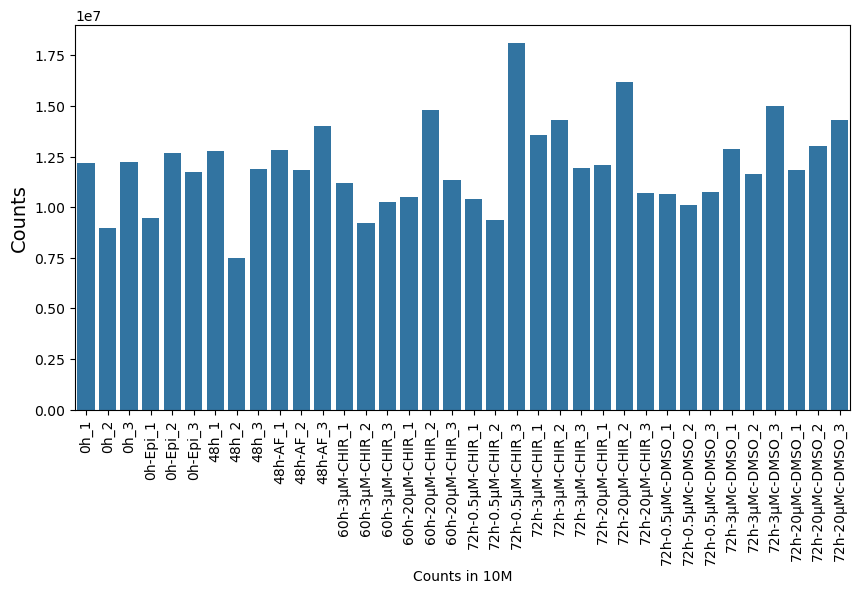

In [315]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.barplot(df_gastruloid, x=df_gastruloid.index, y=df_gastruloid.sum(axis=1),ax=ax)

plt.xticks(rotation=90)
plt.xlabel('Counts in 10M')
plt.ylabel('Counts', size=14)

# create result folder
plt.savefig(f"results/bulk_library_sizes.{save_format}")

**LOGCOUNTS DISTRIBUTION**

In [313]:
#LOGSCALING
log_df=np.log1p(df_gastruloid)

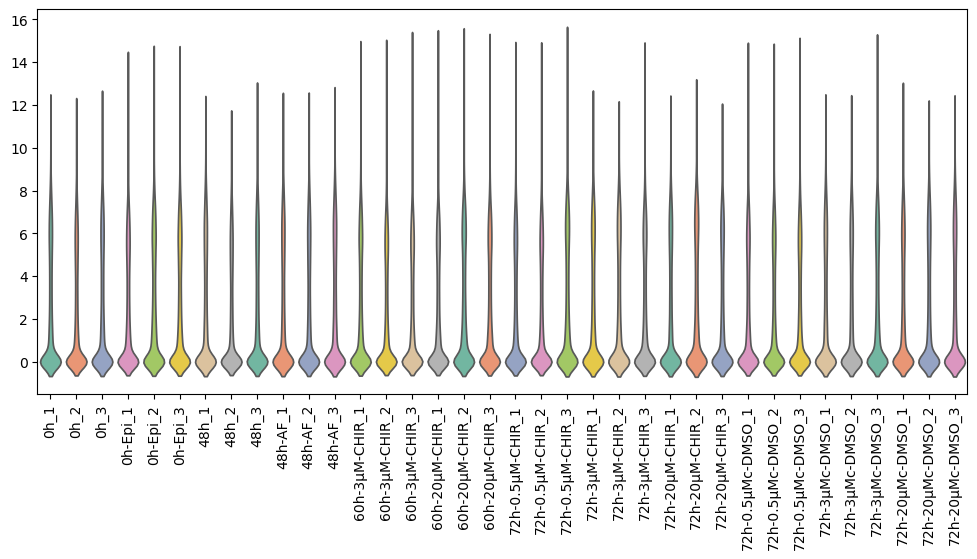

In [316]:
fig,ax=plt.subplots(1,1,figsize=(12,5))

sns.violinplot(log_df.T, palette='Set2',inner=None,ax=ax)
plt.xticks(rotation=90)

plt.savefig(f"results/bulk_logcounts_distribution.{save_format}")

**NORMALIZED COUNTS**

Size factor normalization by median of ratios method

In [317]:
# run deseq2_norm fucntion
dds_norm=deseq2_norm(df_gastruloid)

dds_norm[0].T.to_csv(f"data/normalized_counts.csv")

**SAMPLE REMOVAL**

Remove **48h_AF** and **0h_Epi** conditions for the main analysis (later used for supplementary figures)

In [318]:
#Retain only samples of interest
#Counts
df_gastruloid = df_gastruloid.loc[[(("AF" not in i) and ("Epi" not in i)) and (("ActA" not in i)) and (("96h" not in i)) and (("120h" not in i)) and (("CHIR_5" not in i)) for i in df_gastruloid.index.values]]
#Metadata
df_gastruloid_metadata = df_gastruloid_metadata.loc[[(("AF" not in i) and ("Epi" not in i)) and (("ActA" not in i)) and (("96h" not in i)) and (("120h" not in i)) and (("CHIR_5" not in i)) for i in df_gastruloid_metadata.index]]

# Analysis

## Construct DESeq2 object

In [319]:
dds = DeseqDataSet(
    counts=df_gastruloid.values,
    metadata=df_gastruloid_metadata,
    design_factors="Condition",
    refit_cooks=True
)

/home/pau/miniconda3/lib/python3.12/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


## Variance Stabilizing Transformation (VST)

We scale the data normalizing the sum of total counts and producing and scaling to log1p.

In [320]:
# run vst algorithm
# transformed counts are stored in .layers
dds.vst()

Fitting size factors...
... done in 0.03 seconds.



Fitting dispersions...
... done in 4.75 seconds.

Fitting dispersion trend curve...
... done in 0.49 seconds.



In [321]:
# create df with transformed counts
df1= pd.DataFrame(data=dds.layers['vst_counts'],    
             index=dds.obs.index,    
            columns=df_gastruloid.columns.values)

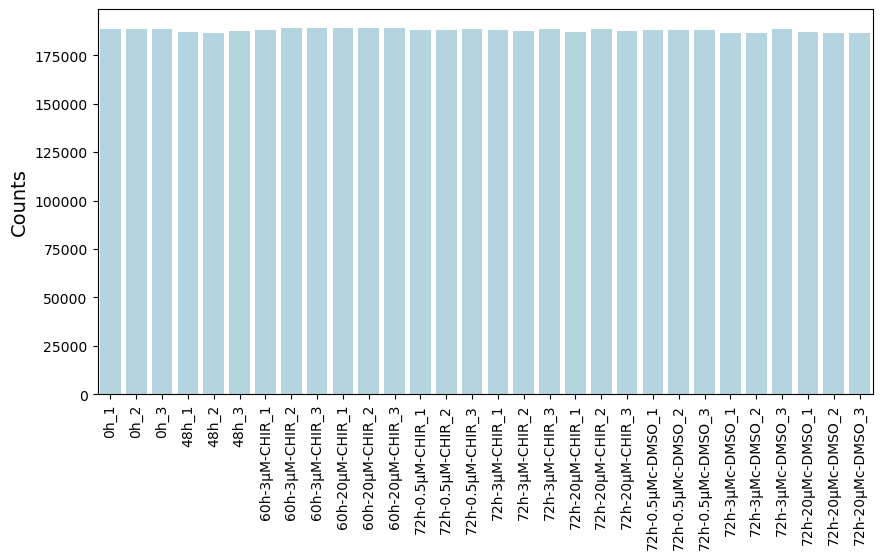

In [322]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.barplot(df1, x=df1.index, y=df1.sum(axis=1),ax=ax, color='lightblue')

plt.xticks(rotation=90)
plt.ylabel('Counts', size=14)
plt.xlabel('')
# create result folder
plt.savefig(f"results/bulk_library_sizes_sizefactoring.{save_format}")

## Feature selection

We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

In [323]:
fs = VarianceThreshold(threshold=1)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

print(f"Genes retained: {len(l)}")

Genes retained: 598


## PCA

<Axes: >

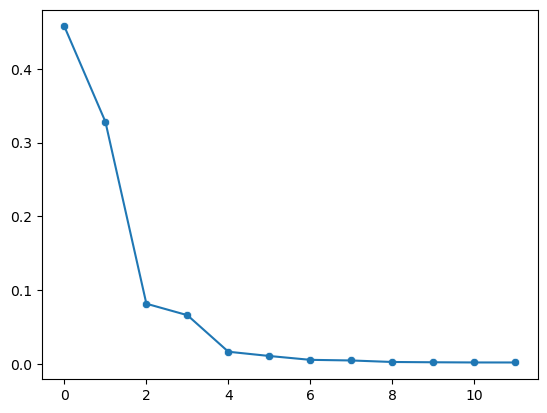

In [324]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=df1.columns.values[l])
pca = PCA(n_components=12)
pca.fit(df1_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)

In [325]:
names = df1.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]]
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=names)
pca = PCA(n_components=min(4,df1.shape[0]-1))
pca.fit(fs.transform(df1.values));

In [326]:
x = pca.transform(fs.transform(df1.values))

dds.obs['PC1']=x[:,0]
dds.obs['PC2']=x[:,1]

### Representation

Show the PCA components and the Pijuan-Sala projection. The PCA captures time evolution.

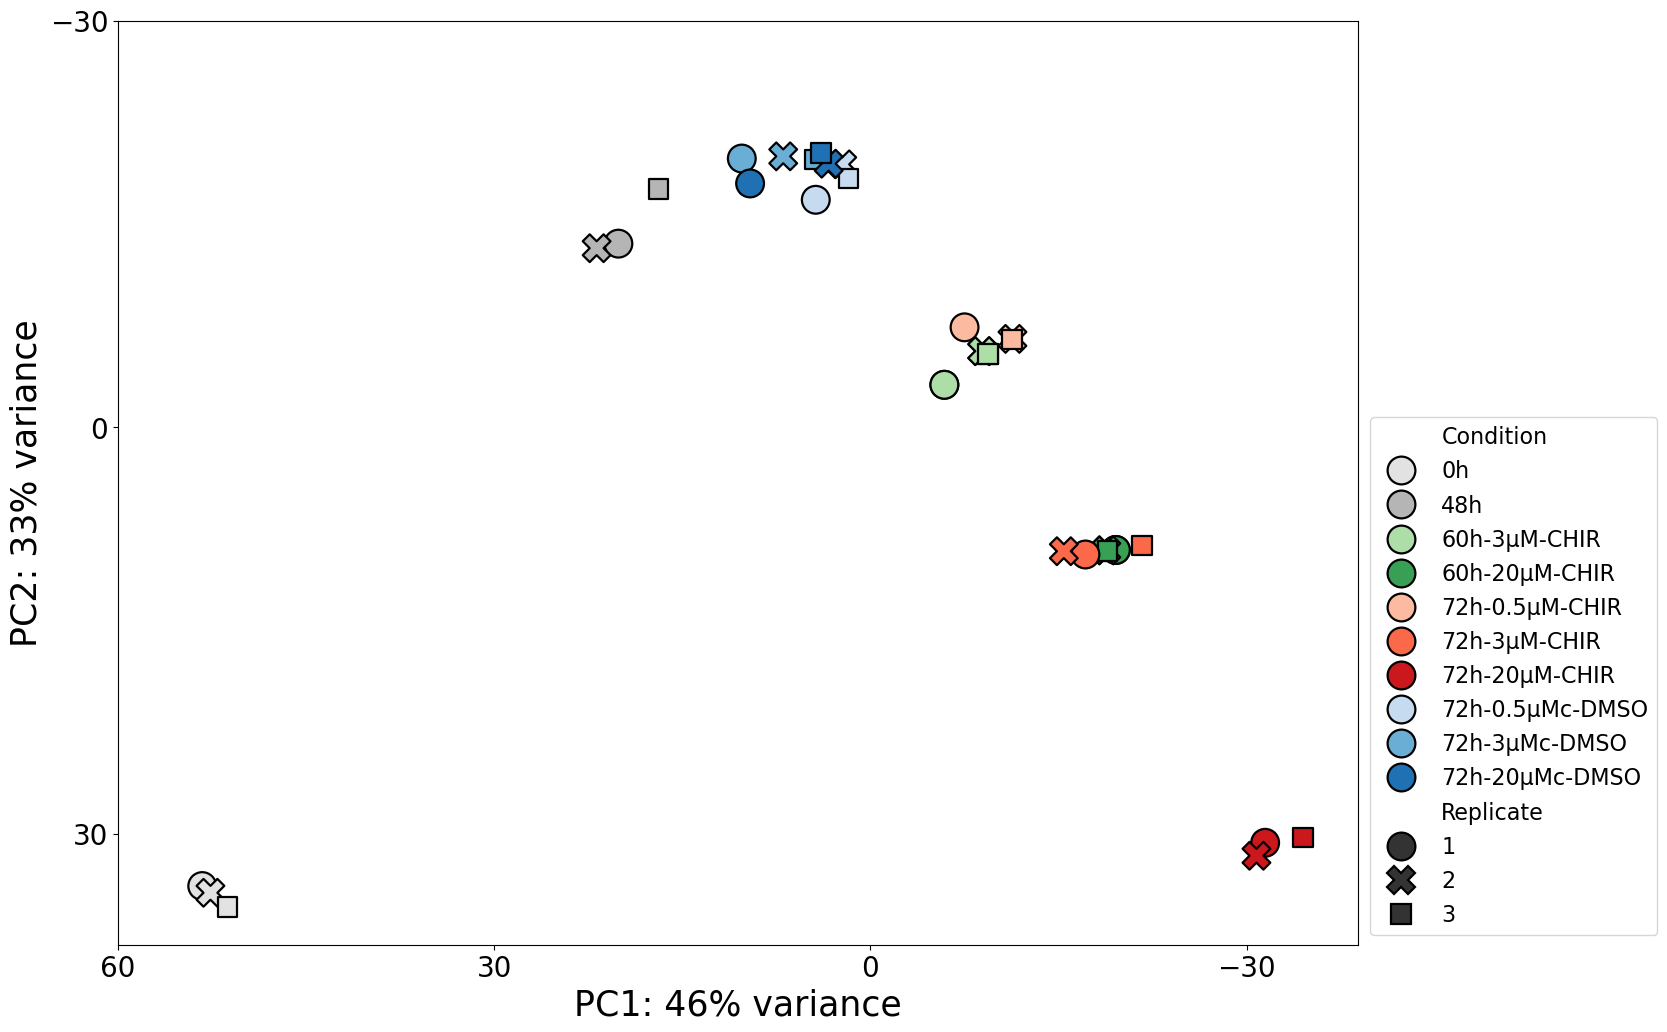

In [327]:
fig,ax=plt.subplots(1,1,figsize=(16,12))
sns.scatterplot(dds.obs[['0h' in i or '48h' in i for i in dds.obs.index.values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='Greys')
sns.scatterplot(dds.obs[['60h' in i  for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black',
                        style='Replicate', hue='Condition', ax=ax, palette='Greens')
sns.scatterplot(dds.obs[['72h' in i and 'CHIR' in i for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Reds')
sns.scatterplot(dds.obs[['72h' in i and 'DMSO' in i for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Blues')

# axes
plt.xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=25)
plt.ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=25)

#
ax.set_xticks([-30,0, 30, 60])
plt.xticks(fontsize=20)
ax.set_yticks([-30,0, 30])
plt.yticks(fontsize=20)
ax.invert_xaxis()
ax.invert_yaxis()

# legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# define order
by_label_ord={}
legend_order=['Condition','0h','48h',
          '60h-3μM-CHIR', '60h-20μM-CHIR',
          '72h-0.5μM-CHIR','72h-3μM-CHIR','72h-20μM-CHIR',
          '72h-0.5μMc-DMSO','72h-3μMc-DMSO','72h-20μMc-DMSO',
          'Replicate', '1','2','3'
         ]
by_label_ord=dict((i,by_label[i]) for i in legend_order)
# increase dot size in legend
# for dot in handles:
#     dot.set_sizes(dot.get_sizes() * 10)
# # add black edge to dots in legend
# for ha in handles:
#     ha.set_edgecolor("black")
#     ha.set_linewidth(2)

plt.legend(by_label_ord.values(), by_label_ord.keys(),prop={'size':16}, loc=(1.01,0.01))

plt.savefig(f"results/bulk_analysis_pca_scatterplot.{save_format}",bbox_inches="tight",transparent=True)

### Loadings

This shows that buttom-left to up-right is capturing changes in genes like (T, Wnt3a, etc.) and up-left to bottom-right capturing expressioon of genes like (Hox-family).

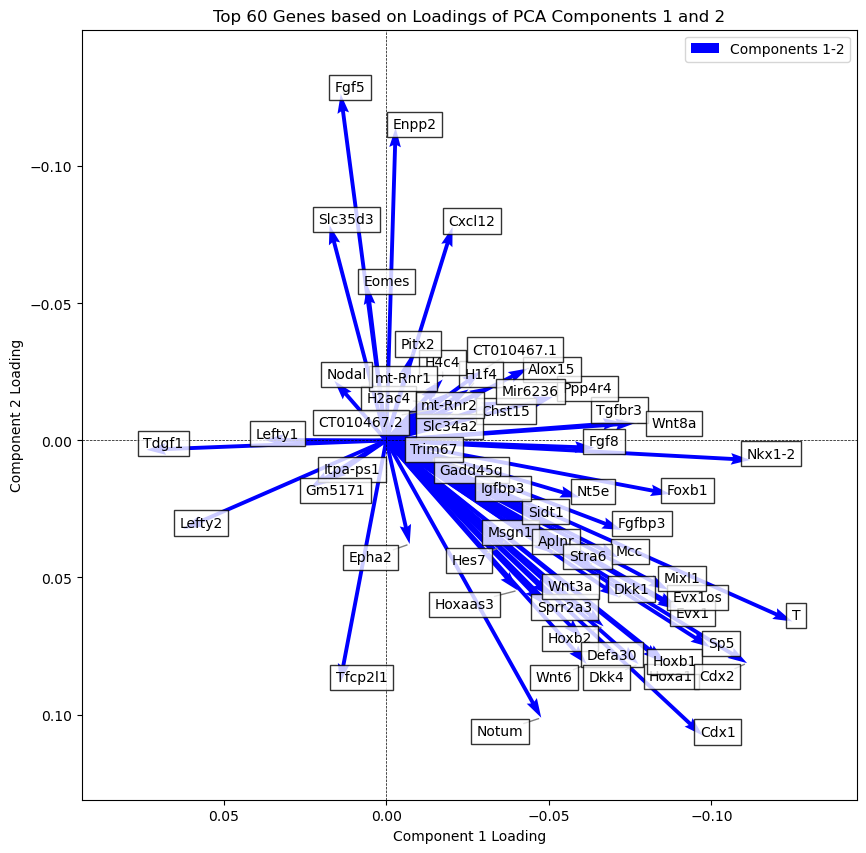

In [328]:
fig, ax = plt.subplots(figsize=(10,10))

plot_loadings_components(pca,0,1,df1_fs.columns.values,60,ax)

ax.invert_xaxis()
ax.invert_yaxis()

plt.savefig(f"results/bulk_analysis_pca_loadings.{save_format}",bbox_inches="tight",transparent=True)

# Marker Genes 

In [329]:
# Marker genes
marker_genes = pd.read_csv("marker_genes.csv",header=None).values[:,0]
marker_genes

array(['Pou5f1', 'Nanog', 'Utf1', 'Sox2', 'Otx2', 'Pou3f1', 'Fgf5',
       'Nodal', 'Eomes', 'Pitx2', 'Wnt3', 'T', 'Cdx1', 'Cdx2', 'Wnt3a',
       'Evx1', 'Nkx1-2', 'Epha1', 'Fst', 'Greb1', 'Gdf11', 'Hoxa1',
       'Hoxb1', 'Hoxb2', 'Hoxc4', 'Hoxb6', 'Hoxb7', 'Hoxb8', 'Hoxb9'],
      dtype=object)

In [330]:
# conditions to retain for heatmap
retain = ['48h','72h-0.5μMc-DMSO','72h-3μMc-DMSO','72h-20μMc-DMSO','72h-0.5μM-CHIR','72h-3μM-CHIR','72h-20μM-CHIR']

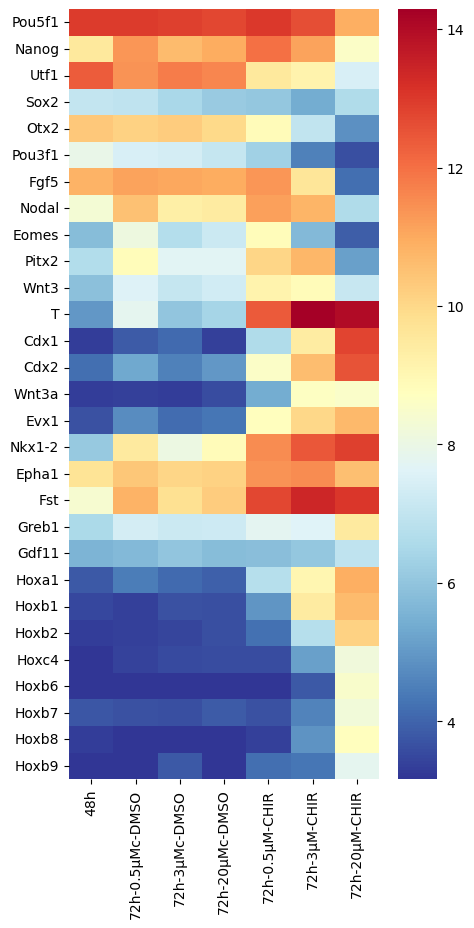

In [331]:
fig, ax = plt.subplots(1,1,figsize=(5,10))

d_ = df1.loc[:,marker_genes].groupby([i[:-2] for i in df_gastruloid_metadata.index]).mean()

sns.heatmap(
    d_.loc[retain,:].transpose(),
    cmap="RdYlBu_r"
)

plt.savefig(f"results/bulk_analysis_marker_genes_heatmap.{save_format}",bbox_inches="tight",transparent=True)